In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *
from decode_fish.funcs.predict import predict
from decode_fish.funcs.exp_specific import *

from omegaconf import open_dict
from hydra import compose, initialize

initialize(config_path="../config")

hydra.initialize()

In [3]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = '1'

# Training
Data taken from https://download.brainimagelibrary.org/cf/1c/cf1c1a431ef8d021/

In [4]:
def README():
    # This data collection contains spatially resolved single-cell transcriptomics datasets acquired using MERFISH on the mouse primary motor cortex (MOp) collected by the Xiaowei Zhuang Lab at Harvard University and Howard Hughes Medical Institute.

    # * The dataset contains MERFISH images of 12 experiments, which include 64 coronal slices of the MOp region (10 um thick slices, every 100um interval) collected from 2 biological replicates. For each mouse, 6 experiments were performed, and each experiment was named with the mouse id plus the sample id, e.g. mouse1_sample1, mouse2_sample3. For each experiment, multiple coronal slices (4-6 slices) were included on the same coverslip and were imaged together.

    # * In this dataset, a total of 258 genes were imaged. Among the 258 genes, 242 genes were imaged using MERFISH, which encodes individual genes with error-robust barcodes (22-bit binary codes in this case), imprints the barcodes onto the RNAs using combinatorial labeling with encoding probes, and measures the barcodes bit-by-bit using sequential hybridization of readout probes. The 22 bits are imaged in 11 hybridization rounds with two-color imaging each round. The remaining 16 genes were imaged by 8 sequential rounds of two-color FISH.

    # * Each of the subdirectory folders contains either the raw (e.g. mouse1_sample1_raw) or processed images (e.g. mouse1_sample1_processed) of one experiment. Each experiment contains many fields of view (FOVs) and each tiff file in the folder corresponds to the images of one FOV. The raw image files are named as aligned_images plus the FOV id (e.g. aligned_images0.tif); the processed image files are named as processed_images plus the FOV id (e.g. processed_images100.tif).

    # â€¢	{sample_id}_raw: folders containing raw images. Each raw image file, corresponding to one FOV, is a stacked tiff file of multiple frames, each frame corresponding to one z-plane of one channel and each channel corresponding to one bit of the MERFISH imaging process, or one gene imaged in the sequential hybridization process, or the DAPI and polyT images used for cell segmentation. Seven z-planes are imaged for each channel. Images are aligned by fiducial bead fitting across each imaging round. The tiff stacks are ordered as channel 1 z-planes 1 through 7, channel 2 z-planes 1 through 7, â€¦, channel 40 z-plane 1 through 7. See data_organization_raw.csv file for detailed channel information.

    # â€¢	{sample_id}_processed: folders containing processed images. Each processed image file, corresponding to one FOV, is a stacked tiff file of multiple frames, each frame corresponding to one z-plane of one channel and each channel corresponding to one bit of the MERFISH imaging process, or the DAPI and polyT images used for cell segmentation. Seven z-planes are imaged for each channel. Images are aligned by fiducial bead fitting across each imaging round, and processed with a high pass filter and deconvolution. The tiff stacks are ordered the same as the raw images, except that images for the genes imaged by straight sequential hybridization are not included. See data_organization_processed.csv file for detailed channel information, and preprocessing.json file for parameters used in image processing. 
    # Note: For the 650 nm channels, a significant number of spots observed the first z-plane (i.e. at the coverslip surface) correspond to non-specific binding of the 650 nm dye to the coverslip surface, and the vast majority of these non-specific binding spots are decoded as invalid barcodes in the decoding process and are not used for subsequent analysis.  

    # * The processed_data folder contains the following files:
    # â€¢	segmented_cells_{sample_id}.csv: Segmented cell boundary coordinates of each z-plane and the slice id that each cell belongs to for each experiment. Note that each experiment includes 4-6 tissue slices on a single coverslip, and the slice id gives the slice number that the cells belong to.
    # â€¢	spots_{sample_id}.csv: Decoded spot location (x,y,z) in the unit of microns and their target gene identity for each experiment. The same coordinate system was used in segmented_cells_{sample_id}.csv and spots_{sample_id}.csv for each experiment, and hence the spots can be parsed into the segmented cells (and also the slices) according by comparison of their coordinates with the cell boundary locations.  
    # â€¢	counts.h5ad: Cell by gene matrix of the whole dataset. The counts are normalized by the volume of each cell.
    # â€¢	cell_labels.csv: Cluster label assignment for each cell.

    # We also provide these files that are associated to this dataset:
    # â€¢	genes_combinatorial.txt: List of target genes that are imaged in combinatorial imaging rounds.
    # â€¢	genes_sequential.txt: List of target genes that are imaged sequentially after the combinatorial imaging rounds.
    # â€¢	probes.fasta: Provides sequences all encoding probes used for hybridization.
    # â€¢	codebook.csv: Provides the barcodes that encode individual genes measured in the combinatorial imaging rounds.
    # â€¢	data_organization_raw.csv: Provides information on how individual channels and z-planes are ordered in the multi-frame tiff file for each field of view of raw images.
    # â€¢	data_organization_processed.csv: Provides information on how individual channels and z-planes are ordered in the multi-frame tiff file for each field of view of processed images.
    # â€¢	microscope.json: Provides parameters of the microscope that was used with pixel size and orientation of images.
    # â€¢	preprocessing.json: Provides values and filters used in generating the processed images.
    # â€¢	fov_positions folder: contains the txt files of field of view positions for individual samples, named by its sample id.
    
    return

Own Notes: z-bins given in data_organization_raw.csv: 0.,1.5,3.,4.5,6.,7.5,9.

Values in the the prediction files: 0., 1.38248848, 2.76497696, 4.14746544, 5.52995392, 6.9124424 , 8.29493088

1.4 um would correspond to 13 pixels in x-y

In [427]:
cfg = compose(config_name='train.yaml', overrides= ["+exp_type=merfish_MOp"])
# cfg = OmegaConf.create(cfg)

[autoreload of decode_fish.engine.place_psfs failed: Traceback (most recent call last):
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 

Make dataset specific changes

In [428]:
# thetas = [79.11,20.9942,11.0078,41.7738,31.2776,14.7114,37.665,9.66,11.956,23.7223,26.4227,8.6138,46.759,4.8934,9.4187,47.1626,26.786,6.9419,28.795,11.7935,5.9558,23.017]
# thetas = [t / 10 for t in thetas]
# channels_facs = [t / min(thetas) for t in thetas]
thetas = [17.34,13.09,9.42,11.71,8.80,11.20,10.84,7.86,9.15,7.61,8.17,7.60,12.23,4.89,8.04,12.02,8.30,6.04,8.53,8.91,5.82,7.38]
thetas = [t / 10 for t in thetas]
channel_facs = None

In [429]:
cfg.output.project = 'MERFISH_MOp'
# cfg.output.group='sweep_sl_4'
# cfg.sub_name='scaled'

# Path to the recording you want to train the network on. Can also use a * expression to load multiple tiffs (e.g. path/*.tif)
cfg.data_path.image_path = cfg.base_dir + '/datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_images150.tif'

# We initialize the PSF as a Gaussian with the given radii. Should be adjusted to get a rough visual fit between recording and simulation.
cfg.evaluation.reconstruction.crop_sl = 's_[:,:,500:700,1400:1600]'

# Average number of foci per simulated volume. If your data does not contain any foci set this to 0.
cfg.genm.foci.n_foci_avg = 0
# Lower and upper limit of emitters simulated per focus
cfg.genm.foci.n_mol_range: [5,40]

# Sets the intensity scale of the simulation. Should be adjusted to cover observed intensity values 

cfg.genm.prob_generator.low = 0.0002
cfg.genm.prob_generator.high = 0.03

# Set to 'disabled' if you do not have a wandb account.
cfg.output.wandb_mode = 'online'

cfg.network.f_maps = 256
cfg.network.depth = 2
cfg.training.bs = 3

cfg.genm.noise.theta = thetas
cfg.genm.microscope.ch_facs = channel_facs

cfg.sim.roi_mask.percentile = 20
cfg.sim.random_crop.crop_sz = 48

cfg.genm.microscope.norm = 'none'
cfg.genm.microscope.psf_noise = 0.0
cfg.sim.bg_estimation.smoothing.smoothing_filter_size = 9

cfg.genm.intensity_dist.int_conc = 4
cfg.genm.intensity_dist.int_rate = 1.
cfg.genm.intensity_dist.int_loc = 1.

cfg.training.num_iters = 50000
cfg.training.int.enabled = False
cfg.training.mic.enabled = True

cfg.training.bl_loss_scale: 0.005

cfg.genm.microscope.scale = 200
cfg.sim.bg_estimation.fractal.scale = 0

cfg.run_name ='MERFISH_mop_4b'

cfg.training.mic.norm_reg = 0.

cfg.output.log_interval = 300

cfg.genm.emitter_noise.rate_fac = 3.
cfg.genm.emitter_noise.int_fac = 1.

cfg.training.start_mic = 2000
cfg.training.start_int = 100000

cfg.training.net.opt.lr = 1.5e-4
cfg.training.int_option = 3.

In [430]:
# cfg.run_name ='MERFISH_mop_1a_ae'
# cfg.training.int.enabled = True
# cfg.training.mic.enabled = True
# cfg.training.start_mic = 0
# cfg.training.start_int = 0

In [431]:
fname = f'../config/experiment/{cfg.run_name}.yaml'
OmegaConf.save(cfg, fname)
prepend_line(fname, '# @package _global_')
cfg.run_name

'MERFISH_mop_4b'

In [77]:
home_dir = os.getenv("HOME")
print(f'bsub -gpu "num=1" -q gpu_rtx -o {home_dir}/logs/ofish.log -e {home_dir}/logs/efish.log {home_dir}/anaconda3/envs/decode_fish_dev2/bin/python {home_dir}/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment={cfg.run_name} run_name=100genes')

bsub -gpu "num=1" -q gpu_rtx -o /groups/turaga/home/speisera/logs/ofish.log -e /groups/turaga/home/speisera/logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment=MERFISH_mop_4b run_name=100genes


Create the dataloader which samples random subsets from the recorded volumes and generates simulated data that we use for training.  
For visualization purposes it is often better to not sample foci as they distort the colorscale.

In [330]:
n_foci = cfg.genm.foci.n_foci_avg
cfg.genm.foci.n_foci_avg = 0
img_3d, decode_dl = get_dataloader(cfg)
cfg.genm.foci.n_foci_avg = n_foci
psf, noise, micro = load_psf_noise_micro(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (7, 48, 48)
1 volumes


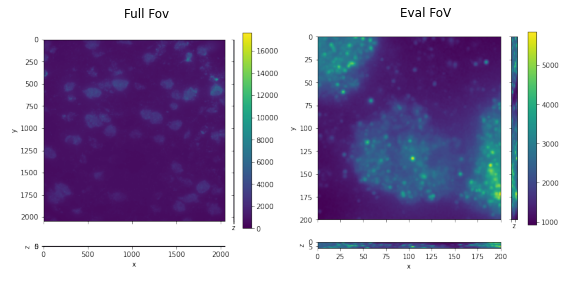

In [46]:
fig1, axes = plot_3d_projections(img_3d[0][5], size=5, proj_func=np.max, display=False)
sl = eval(cfg.evaluation.reconstruction.crop_sl,{'__builtins__': None},{'s_': np.s_})
fig2, axes = plot_3d_projections(img_3d[0][sl][5], size=5, display=False)
_ = combine_figures([fig1,fig2], titles=['Full Fov', 'Eval FoV'])

In [51]:
# plot_channels(img_3d[0][sl], 2, display=False, vmax=20000)

In [52]:
from scipy import stats
def estimate_noise_scale(img, bg_est, percentile=99, plot=True):
    """ Returns an estimate of theta given a volume and a background estimate 
    
    Args:
        img: recorded volume for which we want to estimate the noise 
        bg_est: estimated background for img
        percentile: we wan't to exclude the signal for our fit. therefore we only use the lower percentile of all voxels
        plot: whether to plot the data and the final fit
        
    Returns:
        fit_theta: theta estimate
    """
    
    img = cpu(img)
    bg_est = cpu(bg_est)
    residual = np.clip(img - bg_est + bg_est.mean(), img.min(), 1e10)
    fit_vals = residual[residual < np.percentile(residual, percentile)]
    fit_vals = fit_vals[fit_vals > np.percentile(fit_vals, 100-percentile)]
    fit_alpha, fit_loc, fit_theta=stats.gamma.fit(fit_vals, floc=0)   

    if plot:
        _ = plt.hist(fit_vals,bins=np.linspace(fit_vals.min(),fit_vals.max(), 51),  histtype ='step',label='data', density=True)
        x = np.linspace(fit_vals.min(),fit_vals.max(),101)
        y = stats.gamma.pdf(x, fit_alpha, fit_loc, fit_theta)
        plt.plot(x, y, label='Fit')
        plt.legend()
        
    return fit_theta

In [53]:
# img = load_tiff_image(cfg.data_path.image_path)
thetas = []
for i in range(22):
    bg_est = hydra.utils.instantiate(cfg.sim.bg_estimation.smoothing)(img_3d[0][i,:,:500,1500:].to('cuda'))
    theta = estimate_noise_scale(img_3d[0][i,:,:500,1500:], bg_est, percentile=99, plot=False)
#     plt.show()
    thetas.append(theta)

In [64]:
bench_df, code_ref, targets = hydra.utils.instantiate(cfg.codebook)

In [357]:
# get_simulation_statistics(decode_dl, micro, **cfg.genm.intensity_dist, int_threshold=0.1, samples=5, channels=cfg.genm.exp_type.n_channels, n_bits=cfg.genm.exp_type.n_bits, psf_noise=False, codebook=torch.tensor(code_ref))

# Evaluation

In [450]:
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/sweep_mop_4d/psf_noise:0.15xscale:300xint_option:1xchannel_shifts:True//train.yaml')

In [451]:
bench_df, code_ref, targets = hydra.utils.instantiate(cfg.codebook, return_bench_df=True)
bench_df = get_mop_fov(bench_df, 150)

17130008


In [452]:
# Load the model, post processing, imgages, dataloader
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)
# psf_init = get_gaussian_psf(cfg.genm.PSF.psf_extent_zyx,cfg.genm.PSF.gauss_radii, cfg.genm.exp_type.pred_z, cfg.genm.PSF.n_cols)
psf_init = get_vol_psf(cfg.data_path.psf_path, device='cuda', psf_extent_zyx=None)
psf_init = cpu(psf_init.psf_volume)
psf_vol = cpu(micro.psf.psf_volume)
post_proc.codebook = torch.tensor(code_ref)

Crop size larger than volume in at least one dimension. Crop size changed to (7, 48, 48)
1 volumes


Plot mean projections of the PSF before and after optimizing it during training

(tensor(3.1337, device='cuda:0', grad_fn=<DivBackward0>), tensor(10., device='cuda:0', grad_fn=<DivBackward0>), tensor(10., device='cuda:0', grad_fn=<DivBackward0>))


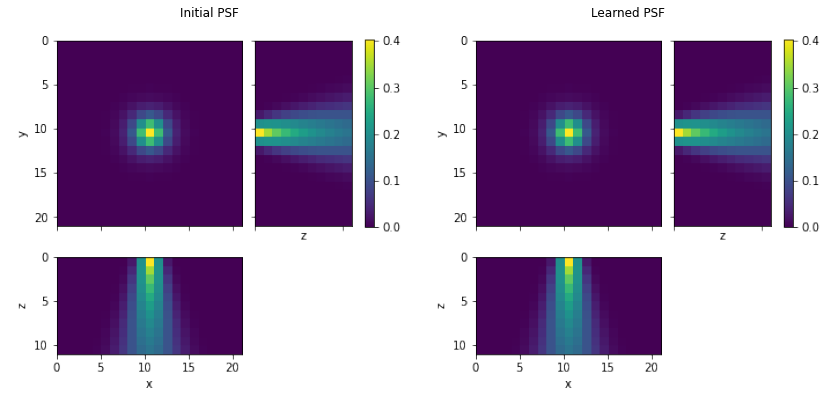

In [453]:
print(micro.psf.get_com())
fig1,_ =plot_3d_projections(psf_vol[1], proj_func=np.mean, size=3, display=False)
fig2,_ =plot_3d_projections(psf_vol[0], proj_func=np.mean, size=3, display=False)
_ = combine_figures([fig1,fig2],['Initial PSF','Learned PSF'], nrows=1, ncols=2, figsize=(15,7))

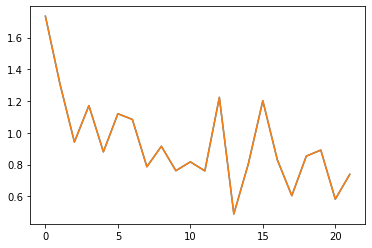

In [454]:
plt.plot(cpu(micro.noise.theta_par.to('cpu')*micro.noise.theta_scale))
plt.plot(thetas)

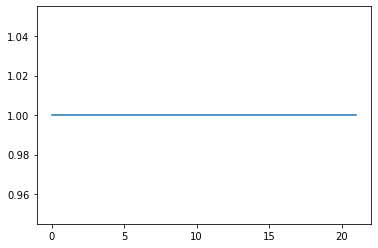

In [455]:
plt.plot(cpu(micro.channel_facs.to('cpu')))

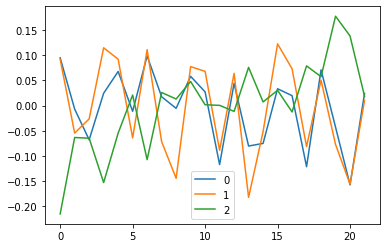

In [456]:
for i in range(3):
    plt.plot(cpu(micro.noise.channel_shifts[:,i]), label=i)
plt.legend()

Sample random sub volumes and overlay them with predictions,  also shows the residuals between the input volume and the reconstruction from applying the microscope and PSF model to those predictions. Sometimes it looks like the network if missing obvious molecules. Often times this is because they are at the very edge of the volume. In that case they will be localized once you process the whole volume.

15


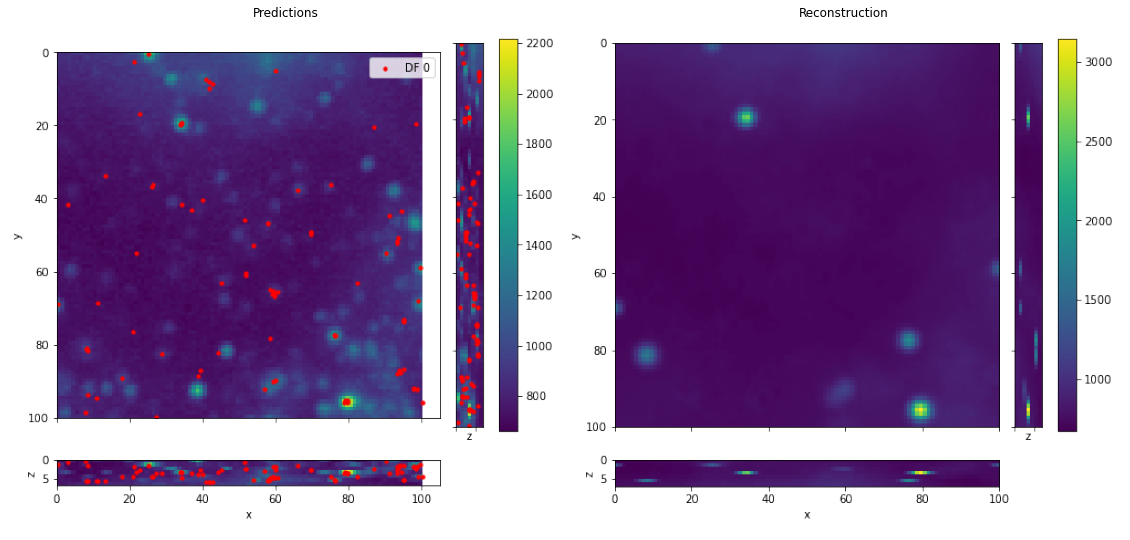

87


In [464]:
x, local_rate, background, pred_df, rec, res_dict, psf_recs, psf_bgs, rois, ch_inp = eval_random_crop(decode_dl, model, post_proc, micro, plot='rec', crop_sz_xy=100, ret_preds=True)
print(len(pred_df))
# eval_random_crop(decode_dl, model, post_proc, micro, samples=10, plot='rec', crop_sz_xy=100, ret_preds=True)

11 0.3019238 4.9981008


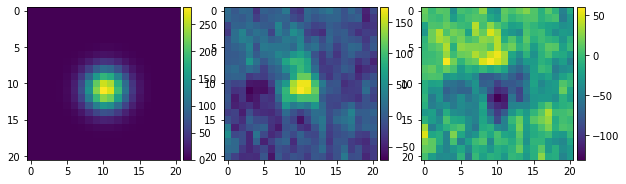

18 0.35873336 4.9981008


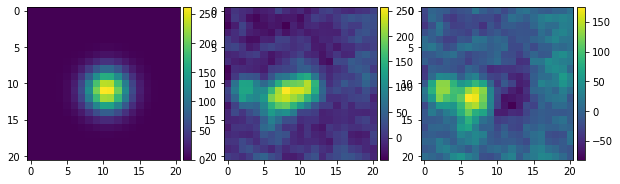

21 0.3200446 4.9981008


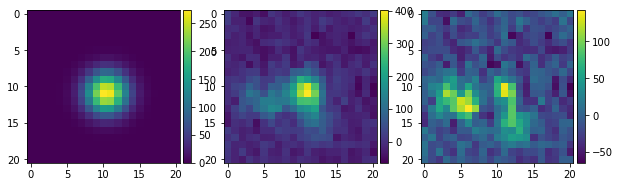

11 0.12305372 5.161194


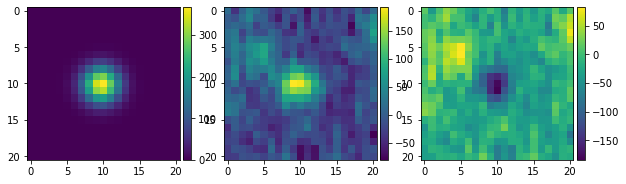

13 0.19837704 5.161194


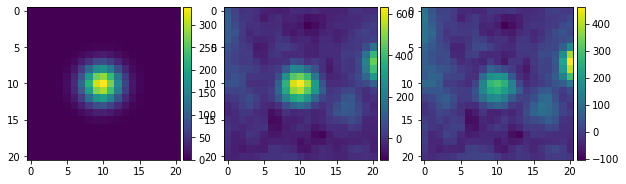

18 0.17986326 5.161194


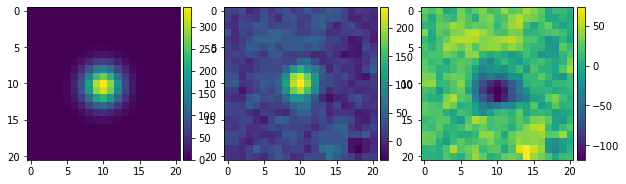

21 0.14117453 5.161194


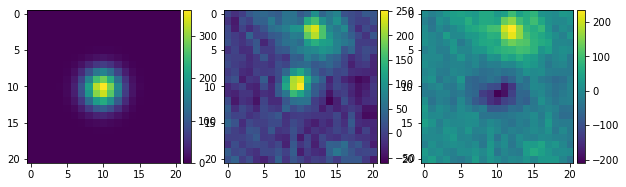

0 -0.16836277 6.6928596


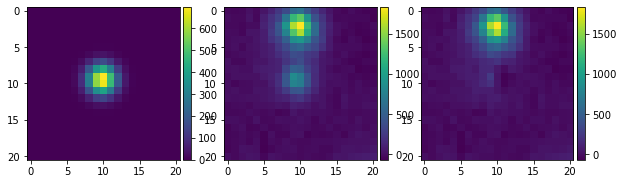

7 0.07235491 6.6928596


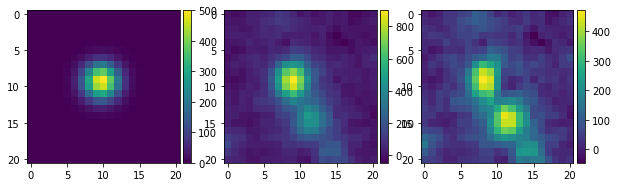

16 0.03382998 6.6928596


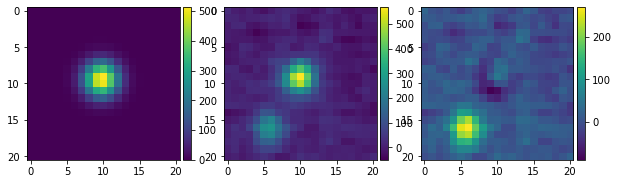

0 -0.14274997 5.7144766


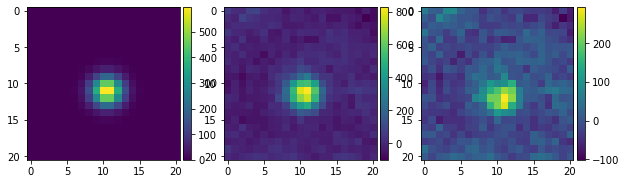

7 0.09796773 5.7144766


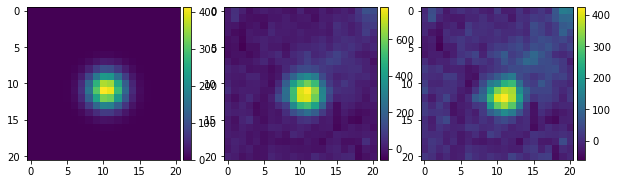

12 0.06050799 5.7144766


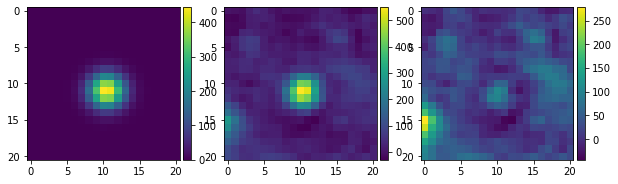

16 0.05944279 5.7144766


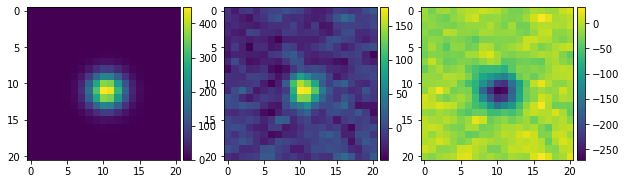

7 0.19383302 5.0440288


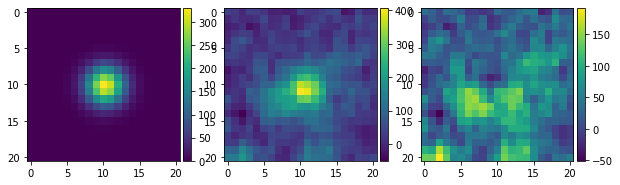

11 0.1683317 5.0440288


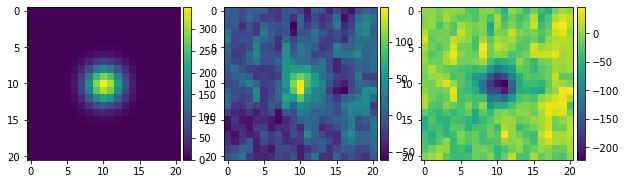

12 0.15637329 5.0440288


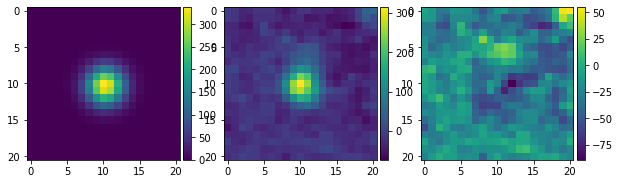

14 0.17515293 5.0440288


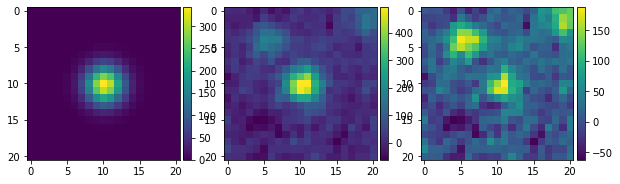

3 -0.13283879 5.1736965


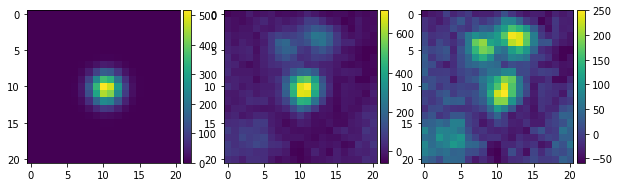

6 -0.08745671 5.1736965


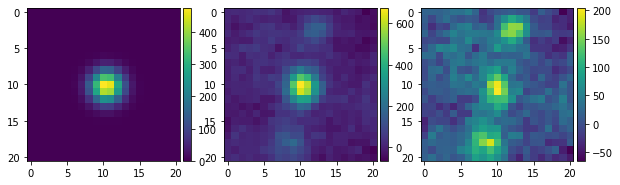

12 0.008257749 5.1736965


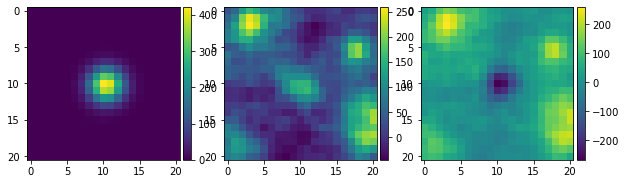

20 0.1578015 5.1736965


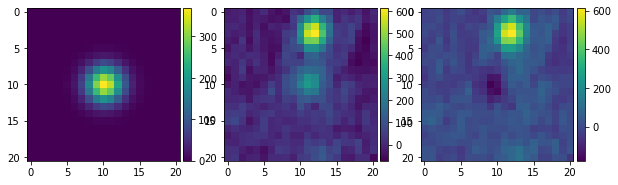

3 0.04626733 5.6775017


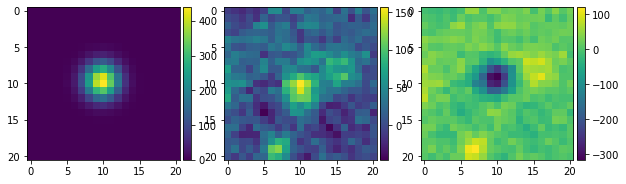

8 0.2119049 5.6775017


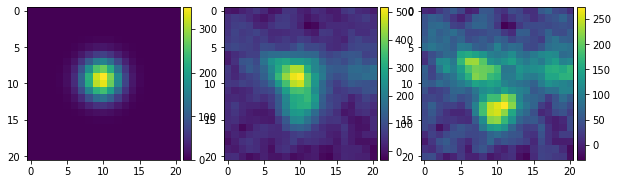

18 0.25613183 5.6775017


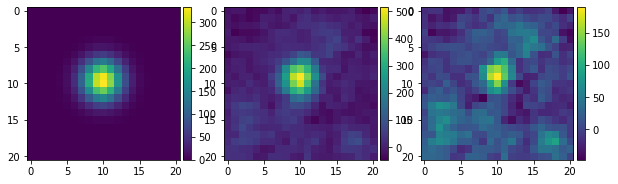

19 0.37601215 5.6775017


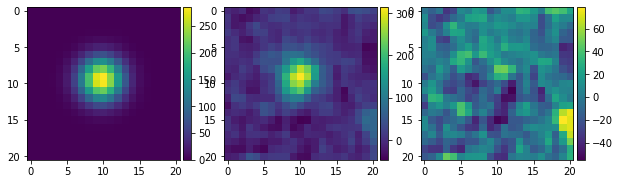

7 0.027189242 5.3654785


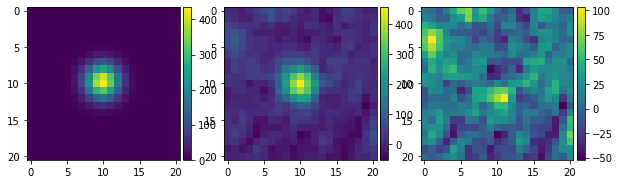

9 0.04900848 5.3654785


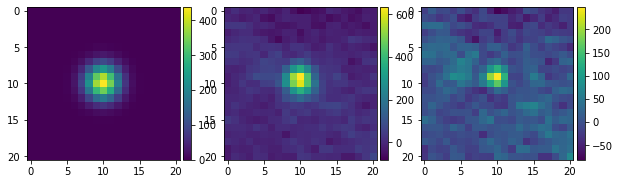

14 0.008509142 5.3654785


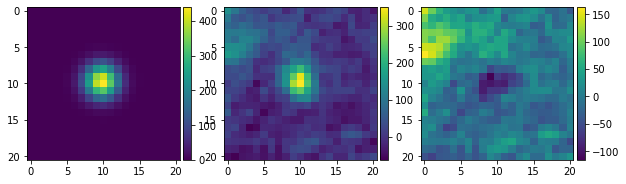

17 0.07994956 5.3654785


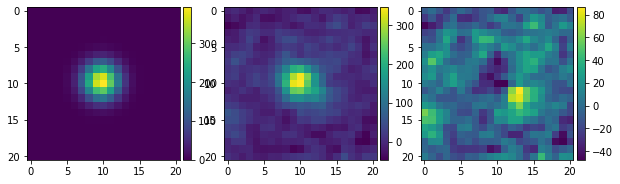

0 -0.2713289 5.284429


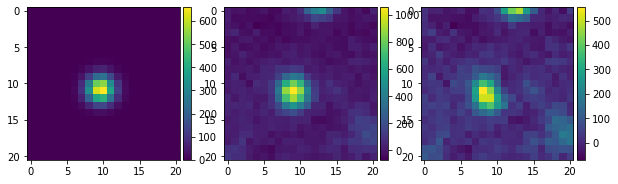

3 -0.20916748 5.284429


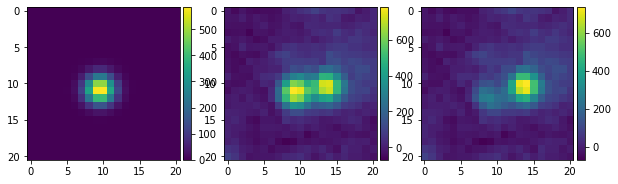

11 -0.056112524 5.284429


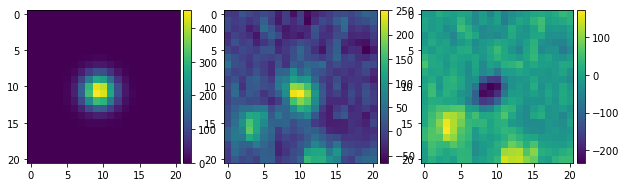

12 -0.06807093 5.284429


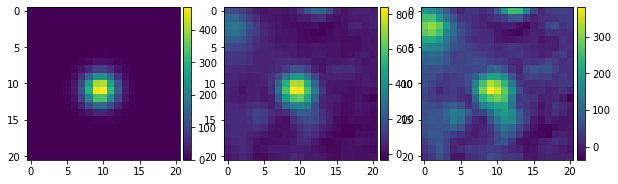

3 -0.32240793 6.2447343


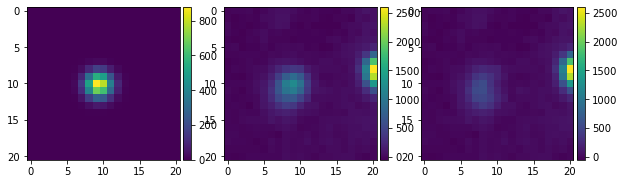

13 -0.094029665 6.2447343


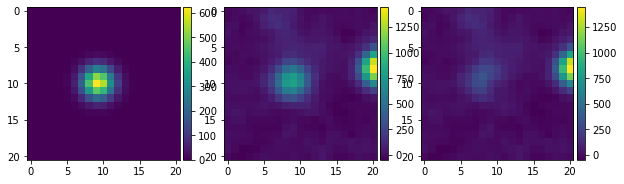

20 -0.03176765 6.2447343


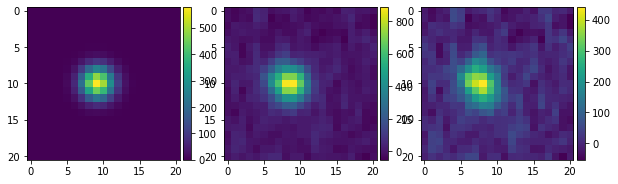

21 -0.15123218 6.2447343


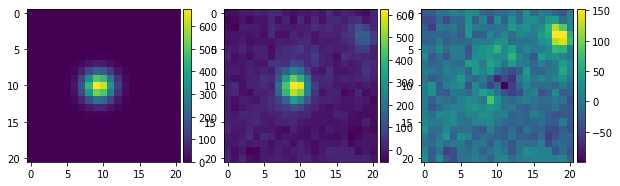

4 -0.13773629 3.594749


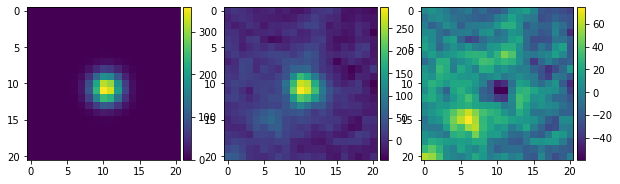

9 -0.035378482 3.594749


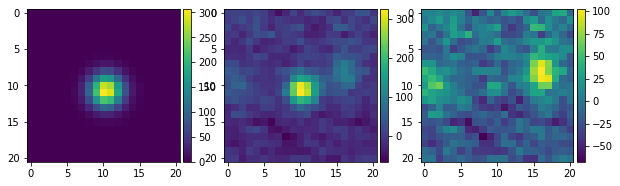

10 -0.081497565 3.594749


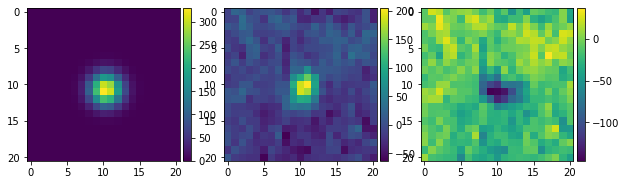

16 -0.09572266 3.594749


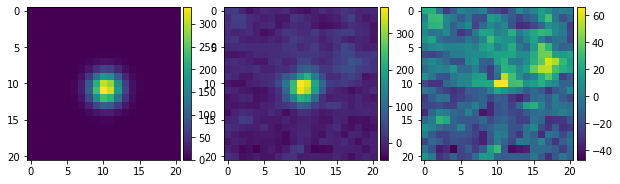

14 -0.03528803 4.545848


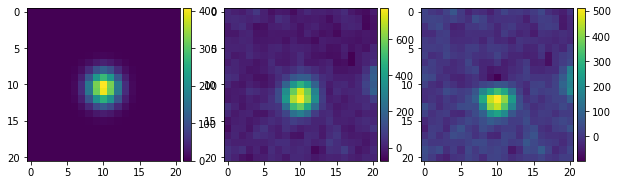

16 -0.055132866 4.545848


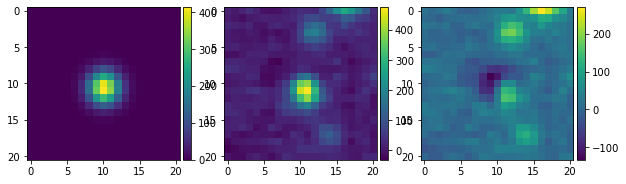

6 0.042900503 4.220733


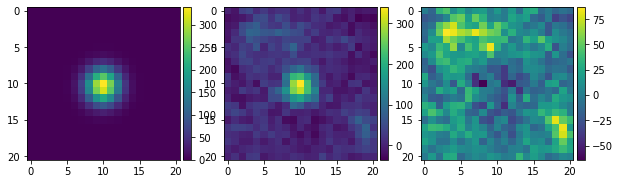

12 0.13861495 4.220733


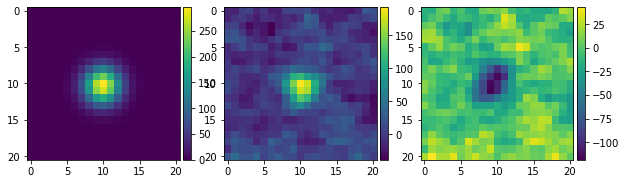

13 0.22589669 4.220733


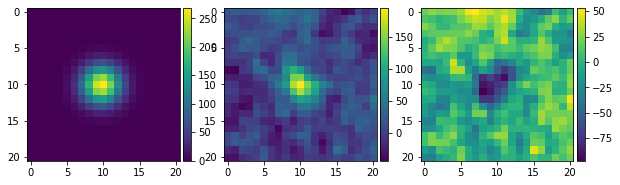

21 0.16869417 4.220733


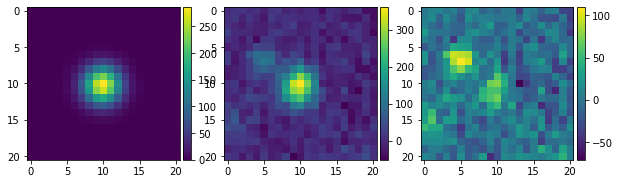

5 -0.1075654 4.512307


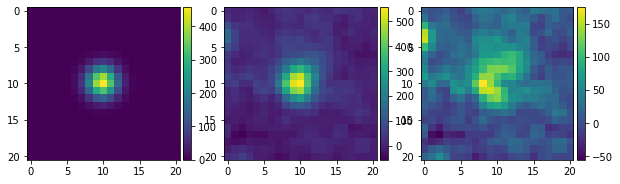

9 -0.08073595 4.512307


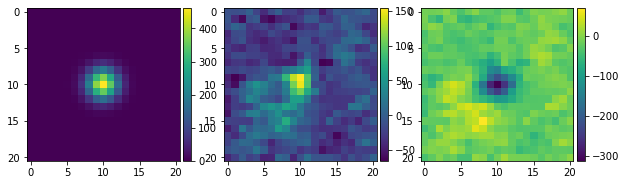

13 -0.052733198 4.512307


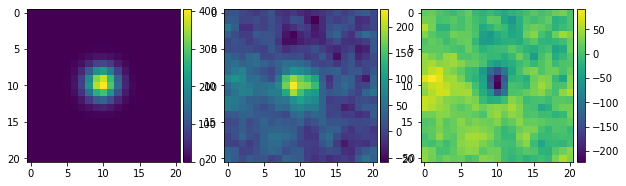

18 -0.07124698 4.512307


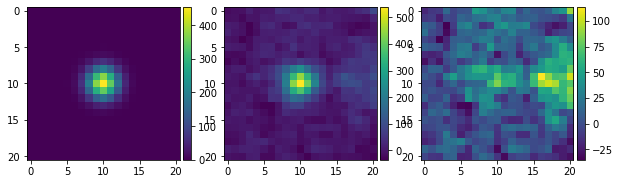

5 0.0007262416 4.771633


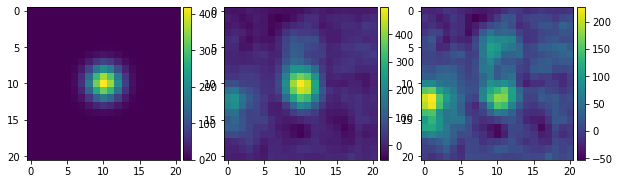

9 0.027555699 4.771633


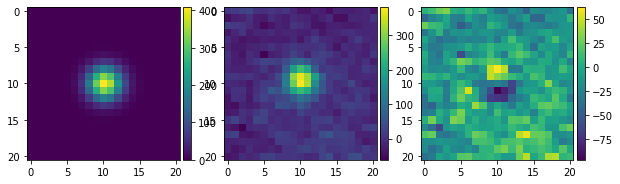

13 0.05555845 4.771633


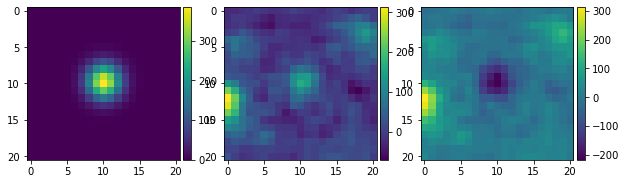

18 0.037044667 4.771633


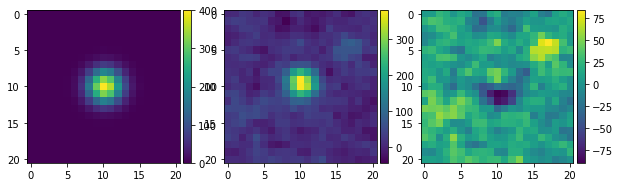

6 0.31354716 3.853462


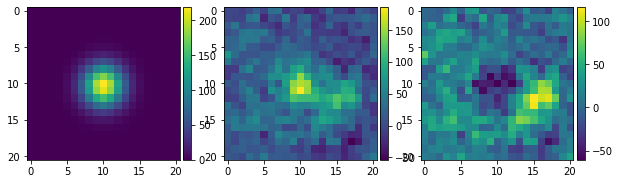

9 0.2500757 5.5493793


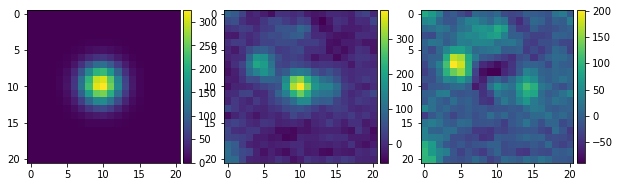

20 0.34034047 5.5493793


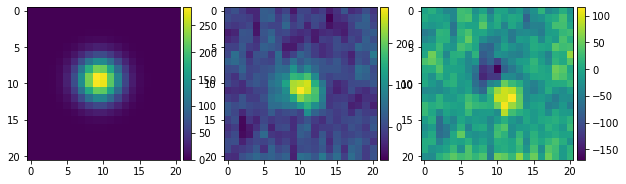

4 -0.049536906 5.6278563


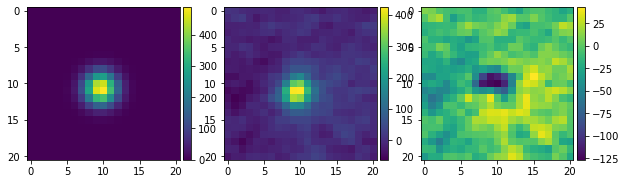

14 0.012321563 5.6278563


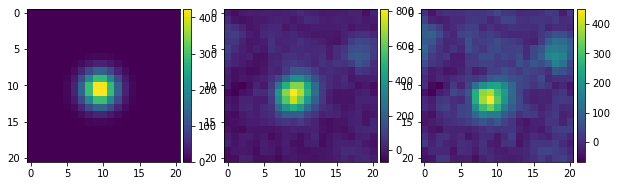

18 0.062309876 5.6278563


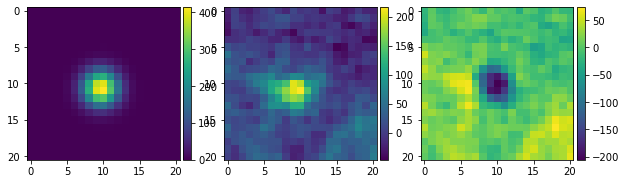

0 -0.26139048 5.512119


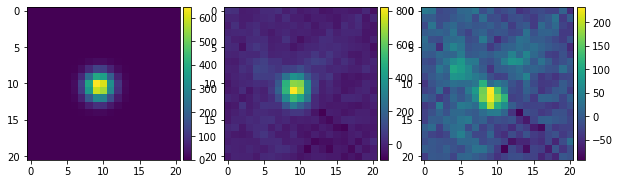

18 0.010635424 5.512119


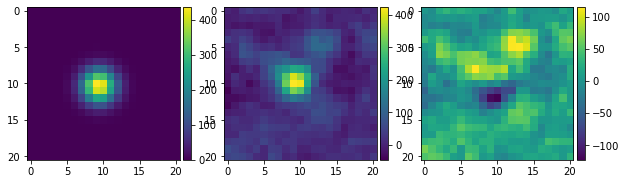

4 0.09763743 5.7122602


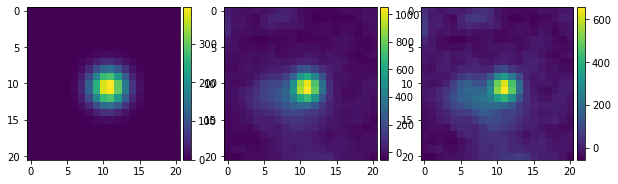

12 0.14071625 5.7122602


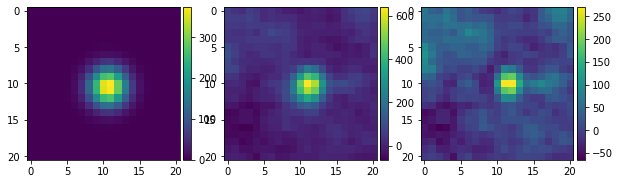

In [467]:
for i in range(len(psf_recs)):
    print(cpu(ch_inp[0][1][i]), cpu(ch_inp[3][i]), cpu(ch_inp[4][i]))
    plt.figure(figsize=(10,3))
    plt.subplot(131)
    im = plt.imshow(cpu(psf_recs)[i,0,0])
    add_colorbar(im)
    plt.subplot(132)
    im = plt.imshow(cpu(rois)[i,0,0]-cpu(psf_bgs)[i,0,0])
    add_colorbar(im)
    plt.subplot(133)
    im = plt.imshow(cpu(rois)[i,0,0]-(cpu(psf_recs)[i,0,0]+cpu(psf_bgs)[i,0,0]))
    add_colorbar(im)
    plt.show()

(4, 6)


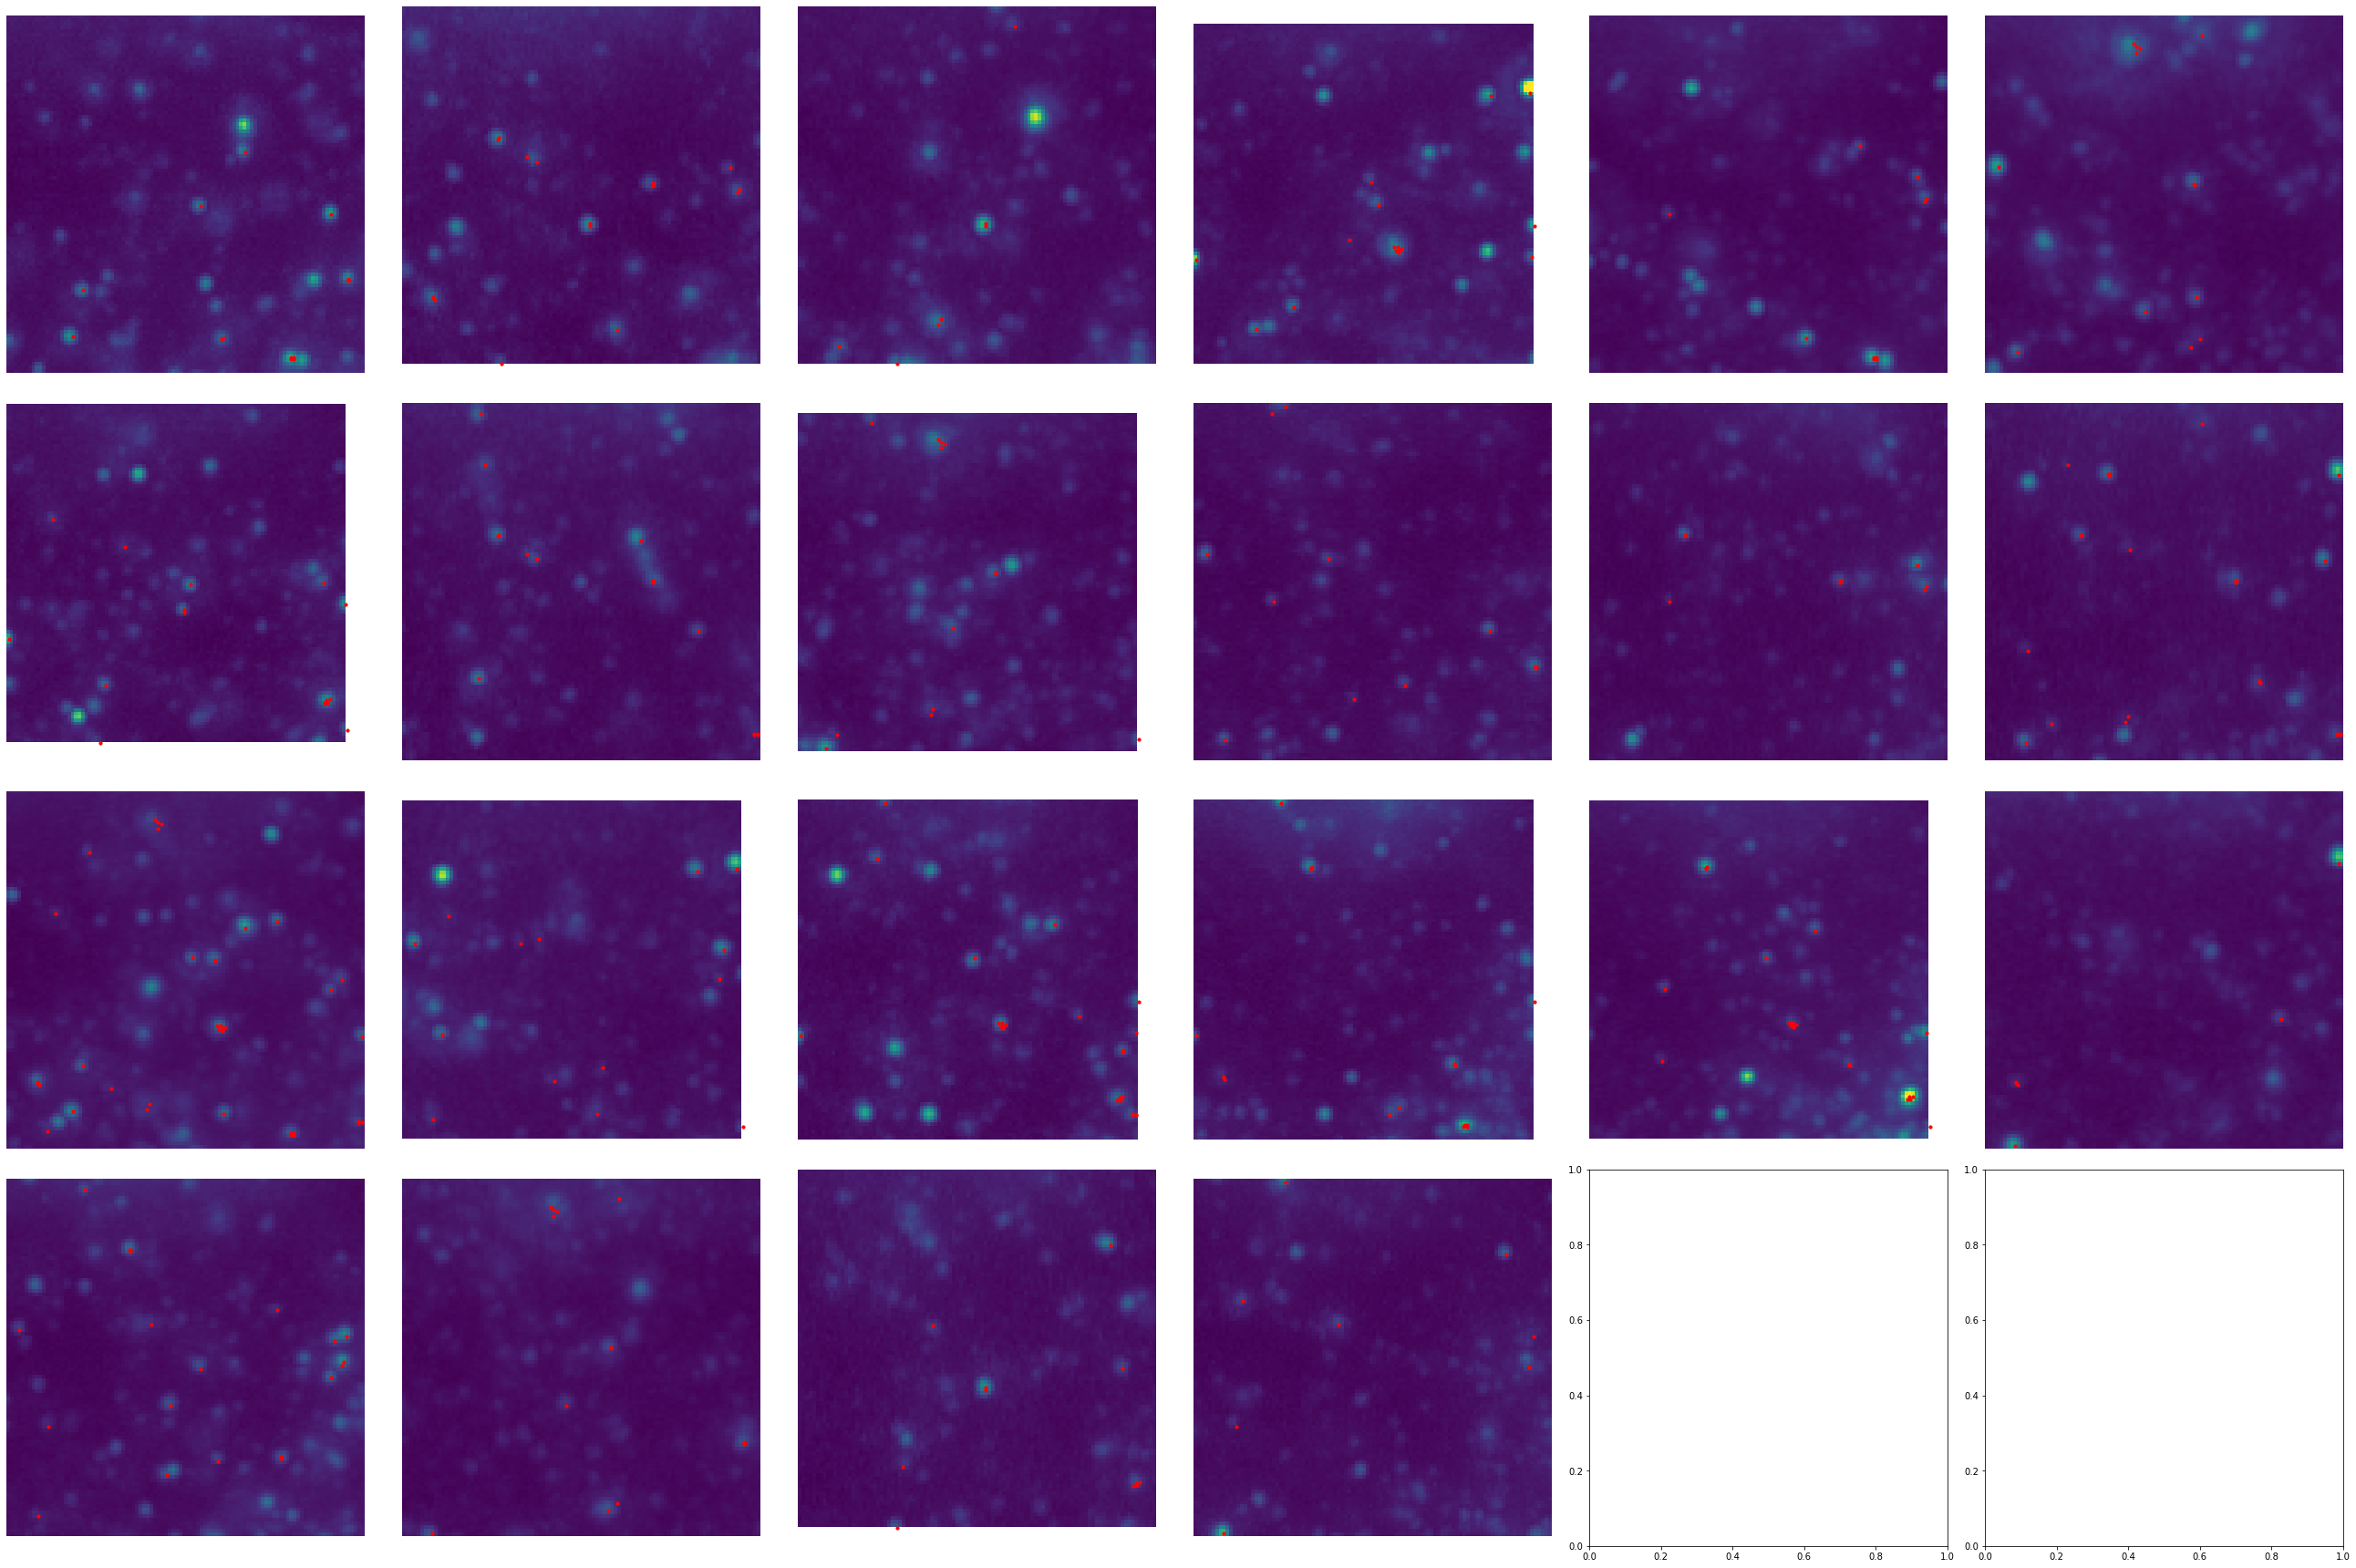

In [466]:
_ = plot_channels(cpu(x[0]), n_rows=4, dfs=[pred_df], codebook=code_ref, vmax=3000)

In [242]:
coords = [27,35,4]
w = 10

plot_vol, crop = extract_roi(x[0], coords, w, w)
fig1, axes =plot_3d_projections(plot_vol[18], display=False)

plot_vol, crop = extract_roi(cpu(torch.sigmoid(res_dict['logits'][0])), coords, w, w)
fig2, axes =plot_3d_projections(plot_vol.max(0), display=False)

_ = combine_figures([fig1,fig2], titles=['x','p'], figsize=(20,10))

NameError: name 'x' is not defined

In [355]:
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.funcs.output_trafo import *
with torch.no_grad():
    
    dl_copy = copy.deepcopy(decode_dl)
    dl_copy.dataset.dataset_tfms[0].crop_sz = (dl_copy.dataset.dataset_tfms[0].crop_sz[0], 60 , 60 )
    
#     x, local_rate, background = next(iter(dl_copy))
    sim_vars = PointProcessUniform(local_rate[:,0]*0.5, int_conc=model.int_dist.int_conc.detach(), 
                                   int_rate=model.int_dist.int_rate.detach(), int_loc=model.int_dist.int_loc.detach(), 
                                   sim_iters=5, channels=cfg.genm.exp_type.n_channels, n_bits=cfg.genm.exp_type.n_bits, 
                                   sim_z=cfg.genm.exp_type.pred_z, codebook=torch.tensor(code_ref, dtype=torch.bool), int_option=cfg.training.int_option).sample(from_code_book=True)
    
    ch_inp = micro.get_single_ch_inputs(sim_vars[0],sim_vars[1],sim_vars[2],sim_vars[3],sim_vars[4],sim_vars[5])
    xsim = micro(*ch_inp, add_noise=True)
    
#     if cfg.genm.emitter_noise.rate_fac:

#         noise_vars = PointProcessUniform(local_rate[:,0]*0.5 * cfg.genm.emitter_noise.rate_fac, int_conc=model.int_dist.int_conc.detach() * cfg.genm.emitter_noise.int_fac, 
#                                        int_rate=model.int_dist.int_rate.detach(), int_loc=model.int_dist.int_loc.detach(), 
#                                        sim_iters=5, channels=cfg.genm.exp_type.n_channels, n_bits=1, 
#                                        sim_z=cfg.genm.exp_type.pred_z, codebook=None, int_option=cfg.training.int_option).sample(from_code_book=False)     

#         xsim += micro(*micro.get_single_ch_inputs(*noise_vars[:-1]), add_noise=True)
    
    xsimn = micro.noise(xsim, background, const_theta_sim=cfg.genm.exp_type.const_theta_sim).sample()

    gt_df = sample_to_df(*sim_vars[:5],sim_vars[-1], px_size_zyx=[1.,1.,1.])

    print(len(gt_df))

    model.eval().cuda()
    res_dict_sim = model(xsimn.cuda())
    res_dict_sim = model.tensor_to_dict(res_dict_sim)
    res_dict_sim['xyzi_mu'][:,3:] = res_dict_sim['xyzi_mu'][:,3:]# * 0  + torch.tensor(gt_ints)[:,:,None,None,None].cuda()
    res_dict_sim['xyzi_sigma'][:,3:] = res_dict_sim['xyzi_sigma'][:,3:] 
#     count_prob, spatial_prob = PointProcessGaussian(**res_dict_sim).log_prob(*sim_vars[:5], 
#                                                   n_bits=cfg.exp_type.n_bits, channels=cfg.exp_type.channels, min_int_sig=cfg.training.net.min_int_sig)
    
    pred_df_sim = post_proc.get_df(res_dict_sim)
    pred_df_sim = nm_to_px(pred_df_sim, post_proc.px_size_zyx)

837


(4, 6)


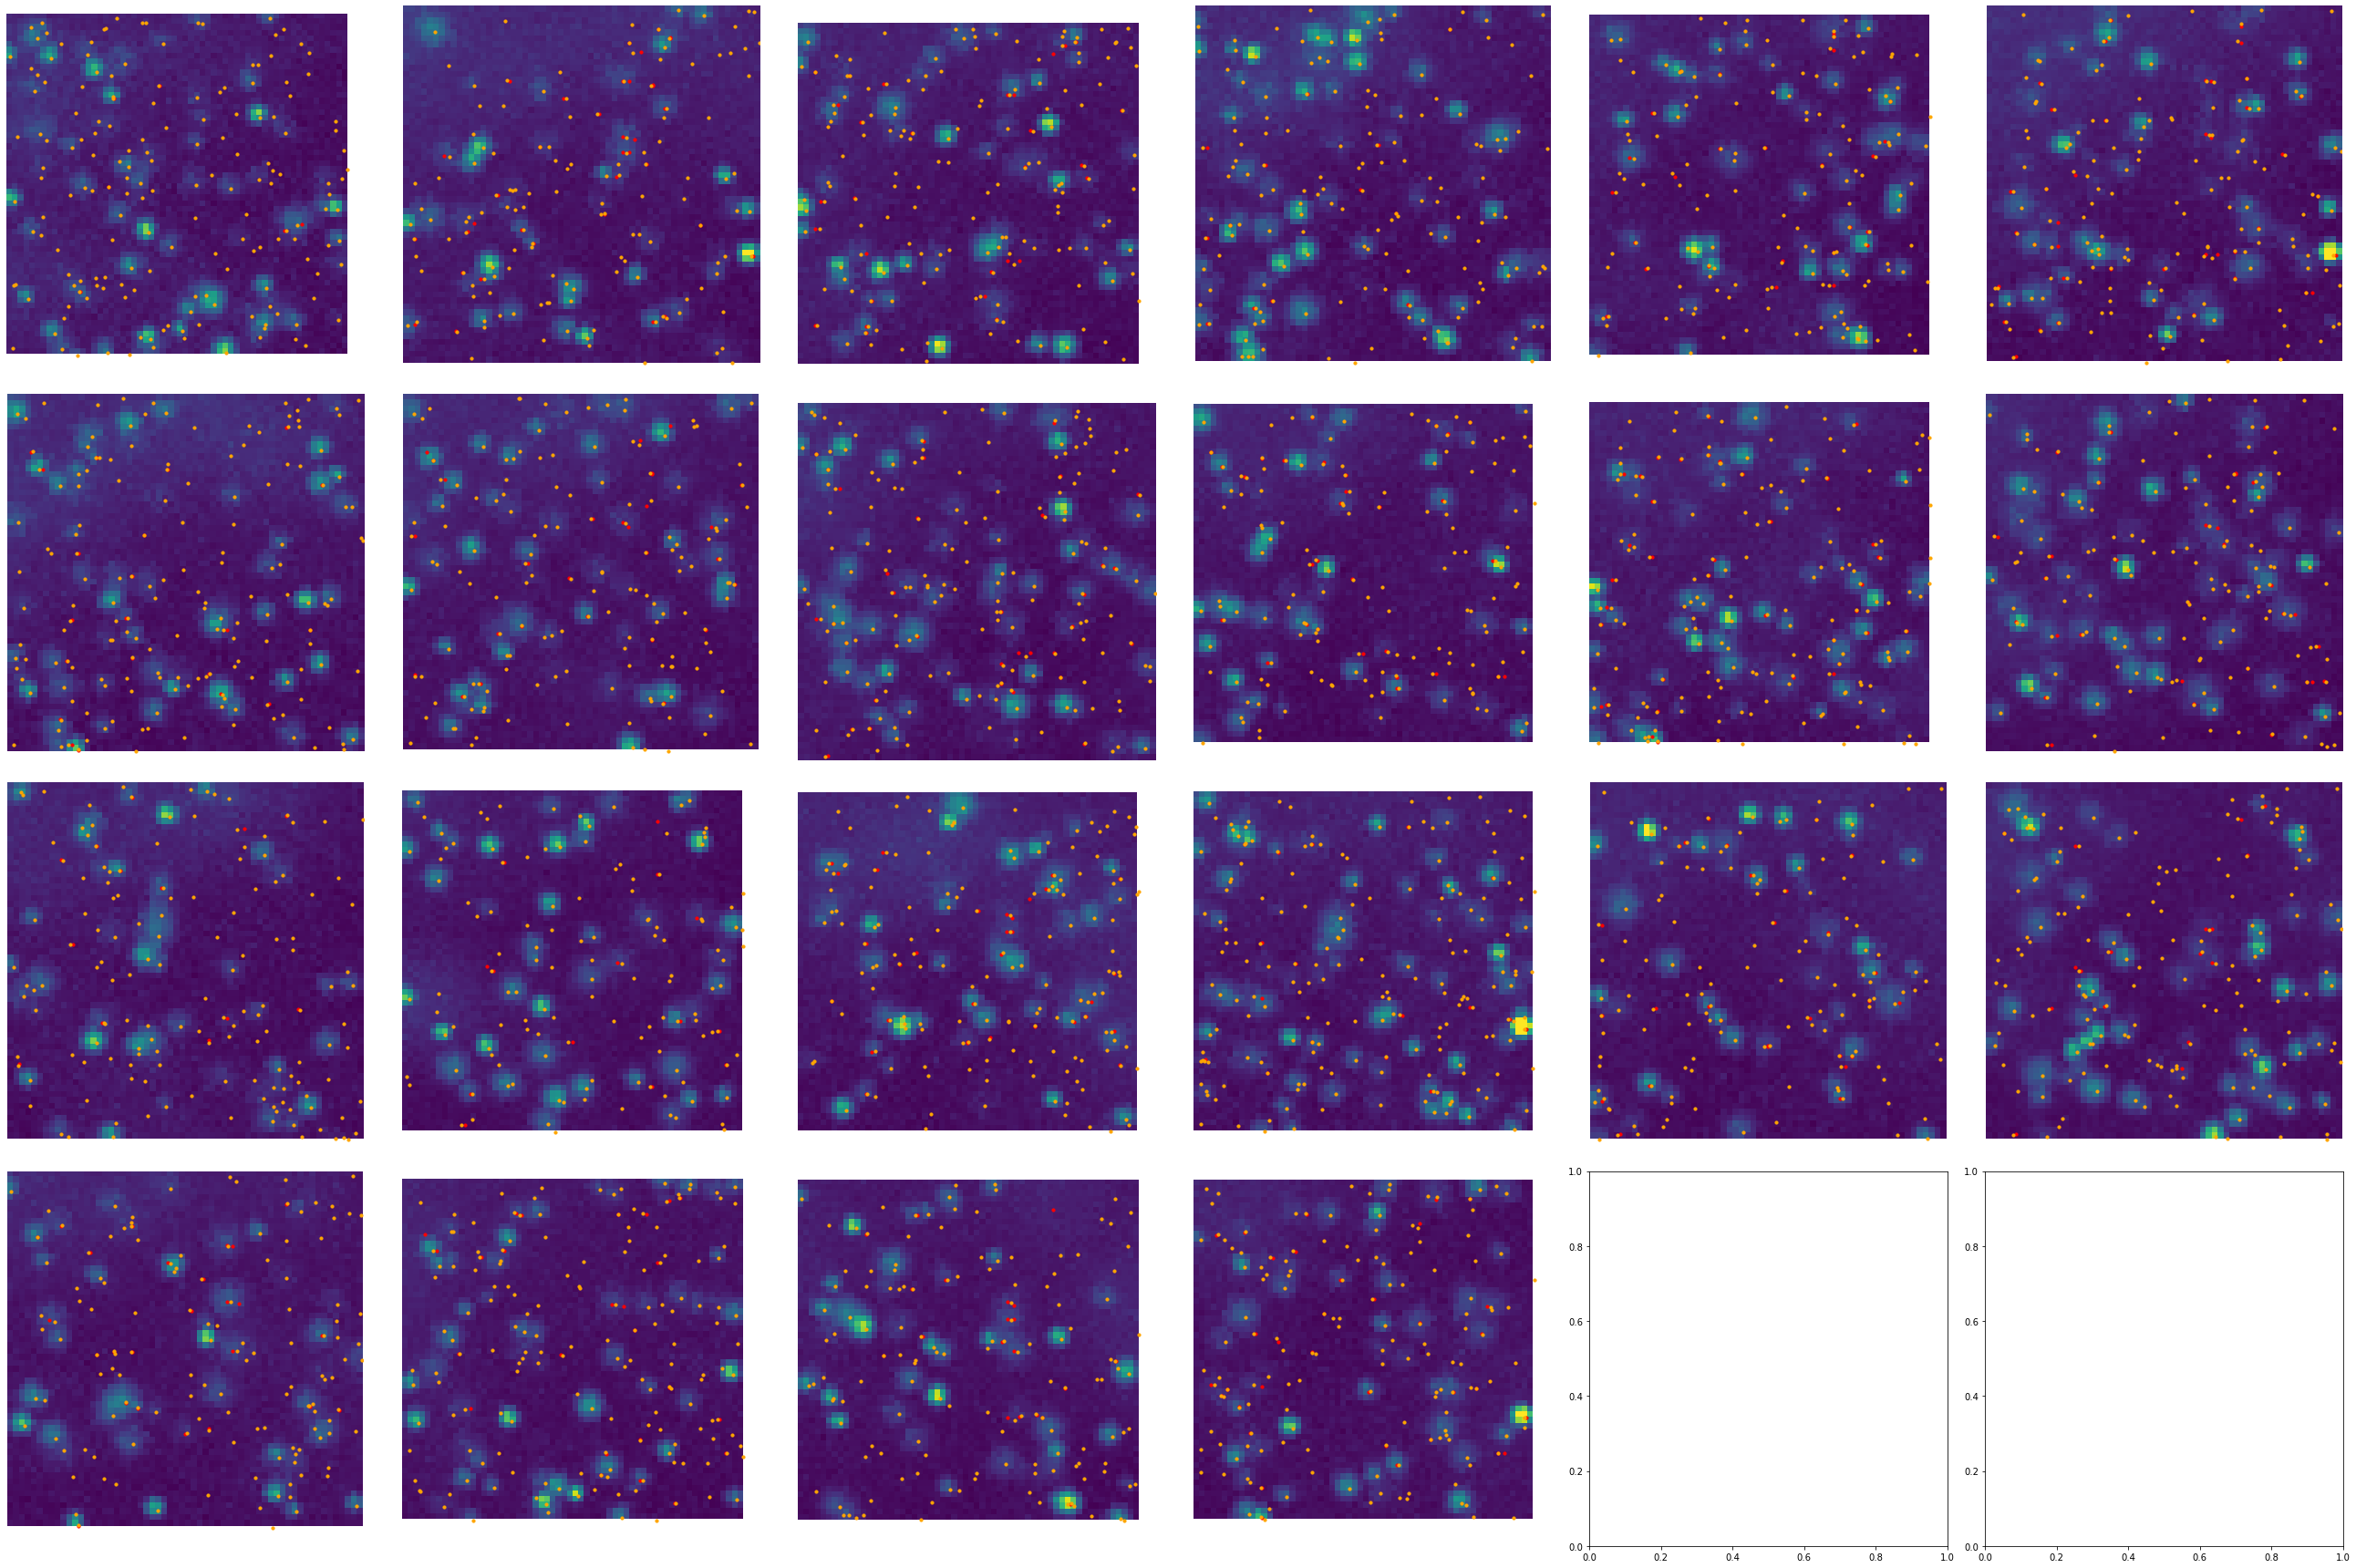

In [356]:
_ = plot_channels(cpu(xsimn[0]), n_rows=4, dfs=[pred_df_sim,gt_df], codebook=code_ref, vmax=2000)

In [447]:
perf, matches, _ = matching(px_to_nm(gt_df), px_to_nm(pred_df_sim), tolerance=500, print_res=True, match_genes=True)

Recall: 0.686
Precision: 0.922
Jaccard: 64.789
RMSE_vol: 34.838
Eff_3d: 60.716
FN: 232.0 FP: 43.0
Num. matches: 506.000
Shift: -2.34,-0.33,4.49


In [468]:
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *

def sim_data(decode_dl, batches, micro, model, channels=1, n_bits=1, sim_z=True, codebook=None):
    
    gt_dfs = []
    xsim_col = []
    
    for _ in range(batches):
        with torch.no_grad():
            x, local_rate, background = next(iter(decode_dl))
            sim_vars = PointProcessUniform(local_rate[:,0]*0.5 ,model.int_dist.int_conc, model.int_dist.int_rate, model.int_dist.int_loc, channels=channels, n_bits=n_bits, sim_z=sim_z, codebook=codebook, int_option=cfg.training.int_option).sample(from_code_book=(codebook is not None))
            ch_inp = micro.get_single_ch_inputs(*sim_vars[:-1])
            xsim = micro(*ch_inp, add_noise=True)
#             x = micro.noise(xsim, background*0 + background.mean()).sample()
            x = micro.noise(xsim, background, const_theta_sim=cfg.genm.exp_type.const_theta_sim).sample()

            xsim_col.append(x)

            gt_vars = sim_vars[:-2] 
            gt_df = sample_to_df(*gt_vars, sim_vars[-1], px_size_zyx=[1.,1.,1.])
            gt_dfs.append(gt_df)
        
    return torch.cat(xsim_col), cat_emitter_dfs(gt_dfs, decode_dl.batch_size)

def get_sim_perf(x, gt_df, model, post_proc, micro, cuda=True, print_res=True):

    pred_dfs = []
    x_recs = []
    
    for i in range(len(x)):
        with torch.no_grad():
            pred_df, rec, res_dict, _, _, _, _ = get_prediction(model, post_proc, x[i:i+1], micro=micro, cuda=True, return_rec=True)
            pred_dfs.append(pred_df)
            x_recs.append(rec)
        
    pred_df = cat_emitter_dfs(pred_dfs)
    xrec = torch.cat(x_recs)
    perf, matches, _ = matching(gt_df, pred_df, tolerance=1000, print_res=print_res, match_genes=True)
    perf['mae'] = abs(xrec-rec).mean().item()
    perf['rmse'] = torch.sqrt(((xrec-rec)**2).mean()).item()
    
    return perf, pred_df, matches, res_dict

In [469]:
# x, local_rate, background = next(iter(decode_dl))
# sim_vars = PointProcessUniform(local_rate[:,0]*3 ,model.int_dist.int_conc, model.int_dist.int_rate, model.int_dist.int_loc, channels=22, n_bits=4, sim_z=True, codebook=torch.tensor(code_ref), int_option=cfg.training.int_option).sample(from_code_book=True)
# xsim = micro(*sim_vars[:-1])
# #             x = micro.noise(xsim, background*0 + background.mean()).sample()
# x = micro.noise(xsim, background, const_theta_sim=cfg.genm.exp_type.const_theta_sim).sample()
# pred_df, rec, res_dict = get_prediction(model, post_proc, x, micro=micro, cuda=True, return_rec=True)

# torch.save(res_dict, '../data/model_batch_output_class3.pt')
# torch.save(sim_vars, '../data/sim_var_code_class3.pt')

In [470]:
# from decode_fish.funcs.routines import *
xsim, gt = sim_data(decode_dl, 20, micro, model, channels=22, n_bits=4, sim_z=cfg.genm.exp_type.pred_z, codebook=torch.tensor(code_ref))
perf, pred_df, matches, res_dict = get_sim_perf(xsim, px_to_nm(gt, cfg.evaluation.px_size_zyx), model, post_proc, micro, print_res=True)

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/numba/cuda/compiler.py:865: NumbaPerformanceWarning: Grid size (35) < 2 * SM count (160) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/numba/cuda/compiler.py:865: NumbaPerformanceWarning: Grid size (69) < 2 * SM count (160) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/numba/cuda/compiler.py:865: NumbaPerformanceWarning: Grid size (138) < 2 * SM count (160) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/numba/cuda/compiler.py:865: NumbaPerformanceWarning: Grid size (111

Recall: 0.757
Precision: 0.863
Jaccard: 67.533
RMSE_vol: 43.055
Eff_3d: 61.044
FN: 1547.0 FP: 764.0
Num. matches: 4807.000
Shift: -0.28,0.42,1.17


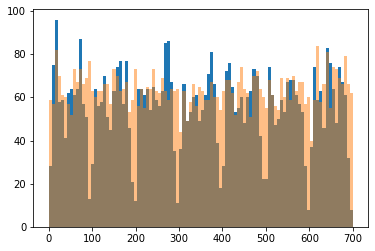

In [471]:
_ = plt.hist(pred_df['z'], bins=np.linspace(0,700,101))
_ = plt.hist(gt['z']*100, bins=np.linspace(0,700,101), alpha=0.5)

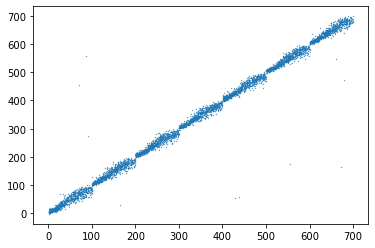

In [472]:
plt.scatter(matches['z_tar'], matches['z_pred'], s=0.1)
# plt.xlim(-50,250)
# plt.ylim(-100,300)

If you are happy with the results you can run the network on whole volumes to get predictions. Be aware that a model will only produce good results on different recordings if the conditions with regards to PSF and intensity are similar as those used during training.

In [159]:
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/sweep_mop_2c/n_foci_avg:0xint_fac:1.0xlr:0.00015/train.yaml')

In [160]:
# model, post_proc, micro, img_3d, decode_dl = load_all(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (7, 48, 48)
1 volumes


In [475]:
from monai.inferers import sliding_window_inference
from decode_fish.funcs.exp_specific import *
def merfish_predict(model, post_proc, image_paths, window_size=[None,256,256], crop=np.s_[:,:,:,:,:], device='cuda'):
    pred_df = DF()
    with torch.no_grad():
        for p in image_paths:
#             print(p.split('/')[-1])
#             img = load_tiff_image(p)[None]
            print(p)
            img = read_MOp_tiff(p, scaled=True)[None]
        
            n_chans = img.shape[1]
            z, y, x = img.shape[-3:]
            inp = img[crop]
            print(inp.shape)
            output = sliding_window_inference(inp, window_size, 1, model.to(device), overlap=0.2, sw_device=device, device='cpu', mode='gaussian')
            output = model.tensor_to_dict(output)
            p_si = sliding_window_inference(output['logits'], window_size, 1, post_proc, overlap=0.2, sw_device=device, device='cpu', mode='gaussian')
            i_df = post_proc.get_df(output, p_si)
#             print('N. emitters: ', len(i_df))
            i_df.loc[:,'frame_idx'] = 0
            pred_df = append_emitter_df(pred_df, i_df)
            free_mem()
        return pred_df

In [476]:
res_df = merfish_predict(model, post_proc, [cfg.data_path.image_path], window_size=[None, 128, 128], crop=np.s_[:,:,:,500:1500,500:1500], device='cuda')
res_df['gene'] = targets[res_df['code_inds']]
print(len(res_df))

/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_images150.tif
torch.Size([1, 22, 7, 1000, 1000])
40000


In [478]:
from decode_fish.funcs.merfish_eval import *
# bench_df, code_ref, targets = hydra.utils.instantiate(cfg.codebook, return_bench_df=True)
bench_df, code_ref, targets = get_merfish_mop(return_bench_df=True)
bench_df = get_mop_fov(bench_df, 150)
bench_df = nm_to_px(bench_df, [1.085,1.085,1.085])
bench_df['x'] += 70
bench_df['y'] += 70

17130008


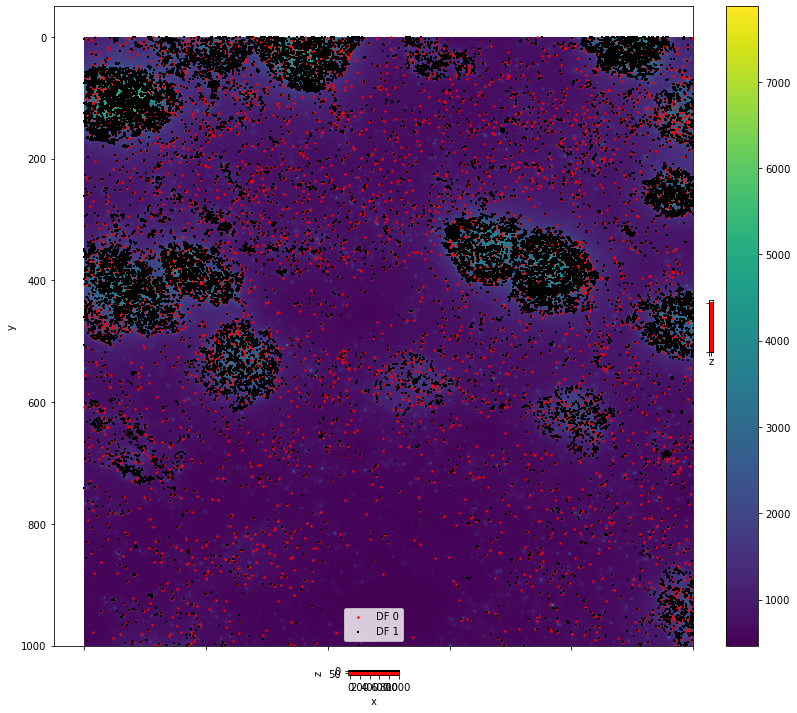

In [480]:
fig, axes = plot_3d_projections(img_3d[0][0,:,500:1500,500:1500], size=10)
bench_sub = crop_df(bench_df, np.s_[:,:,500:1500,500:1500], px_size_zyx=[100., 100., 100.])
# res_sub = crop_df(res_df, np.s_[:,:,500:1000,500:1000], px_size_zyx=[100., 100., 100.])
res_sub = res_df

scat_3d_projections(axes, [nm_to_px(bench_sub, [100.,100.,100.]), nm_to_px(res_sub.nsmallest(40000, 'comb_sig'), [100,100,100])], s_fac=0.2)

In [226]:
pred_df, rec, res_dict = get_prediction(model, post_proc, torch.tensor(plot_vol).to('cuda'), micro=micro, cuda=True, return_rec=True)

NameError: name 'plot_vol' is not defined

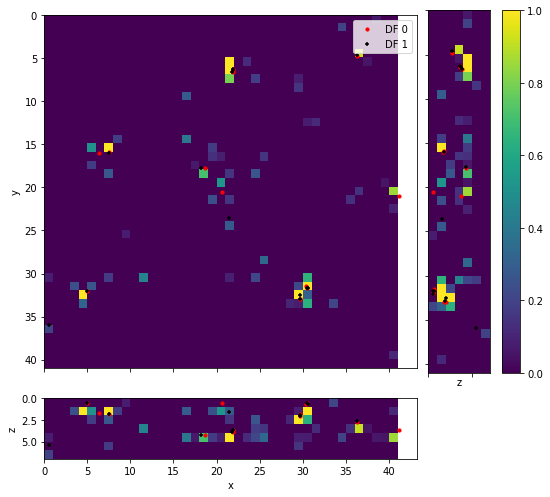

In [433]:
fig,axes = plot_3d_projections(cpu((res_dict['Probs_si']))[0].max(0))
scat_3d_projections(axes, [nm_to_px(pred_df), dfs[1]])

(4, 6)


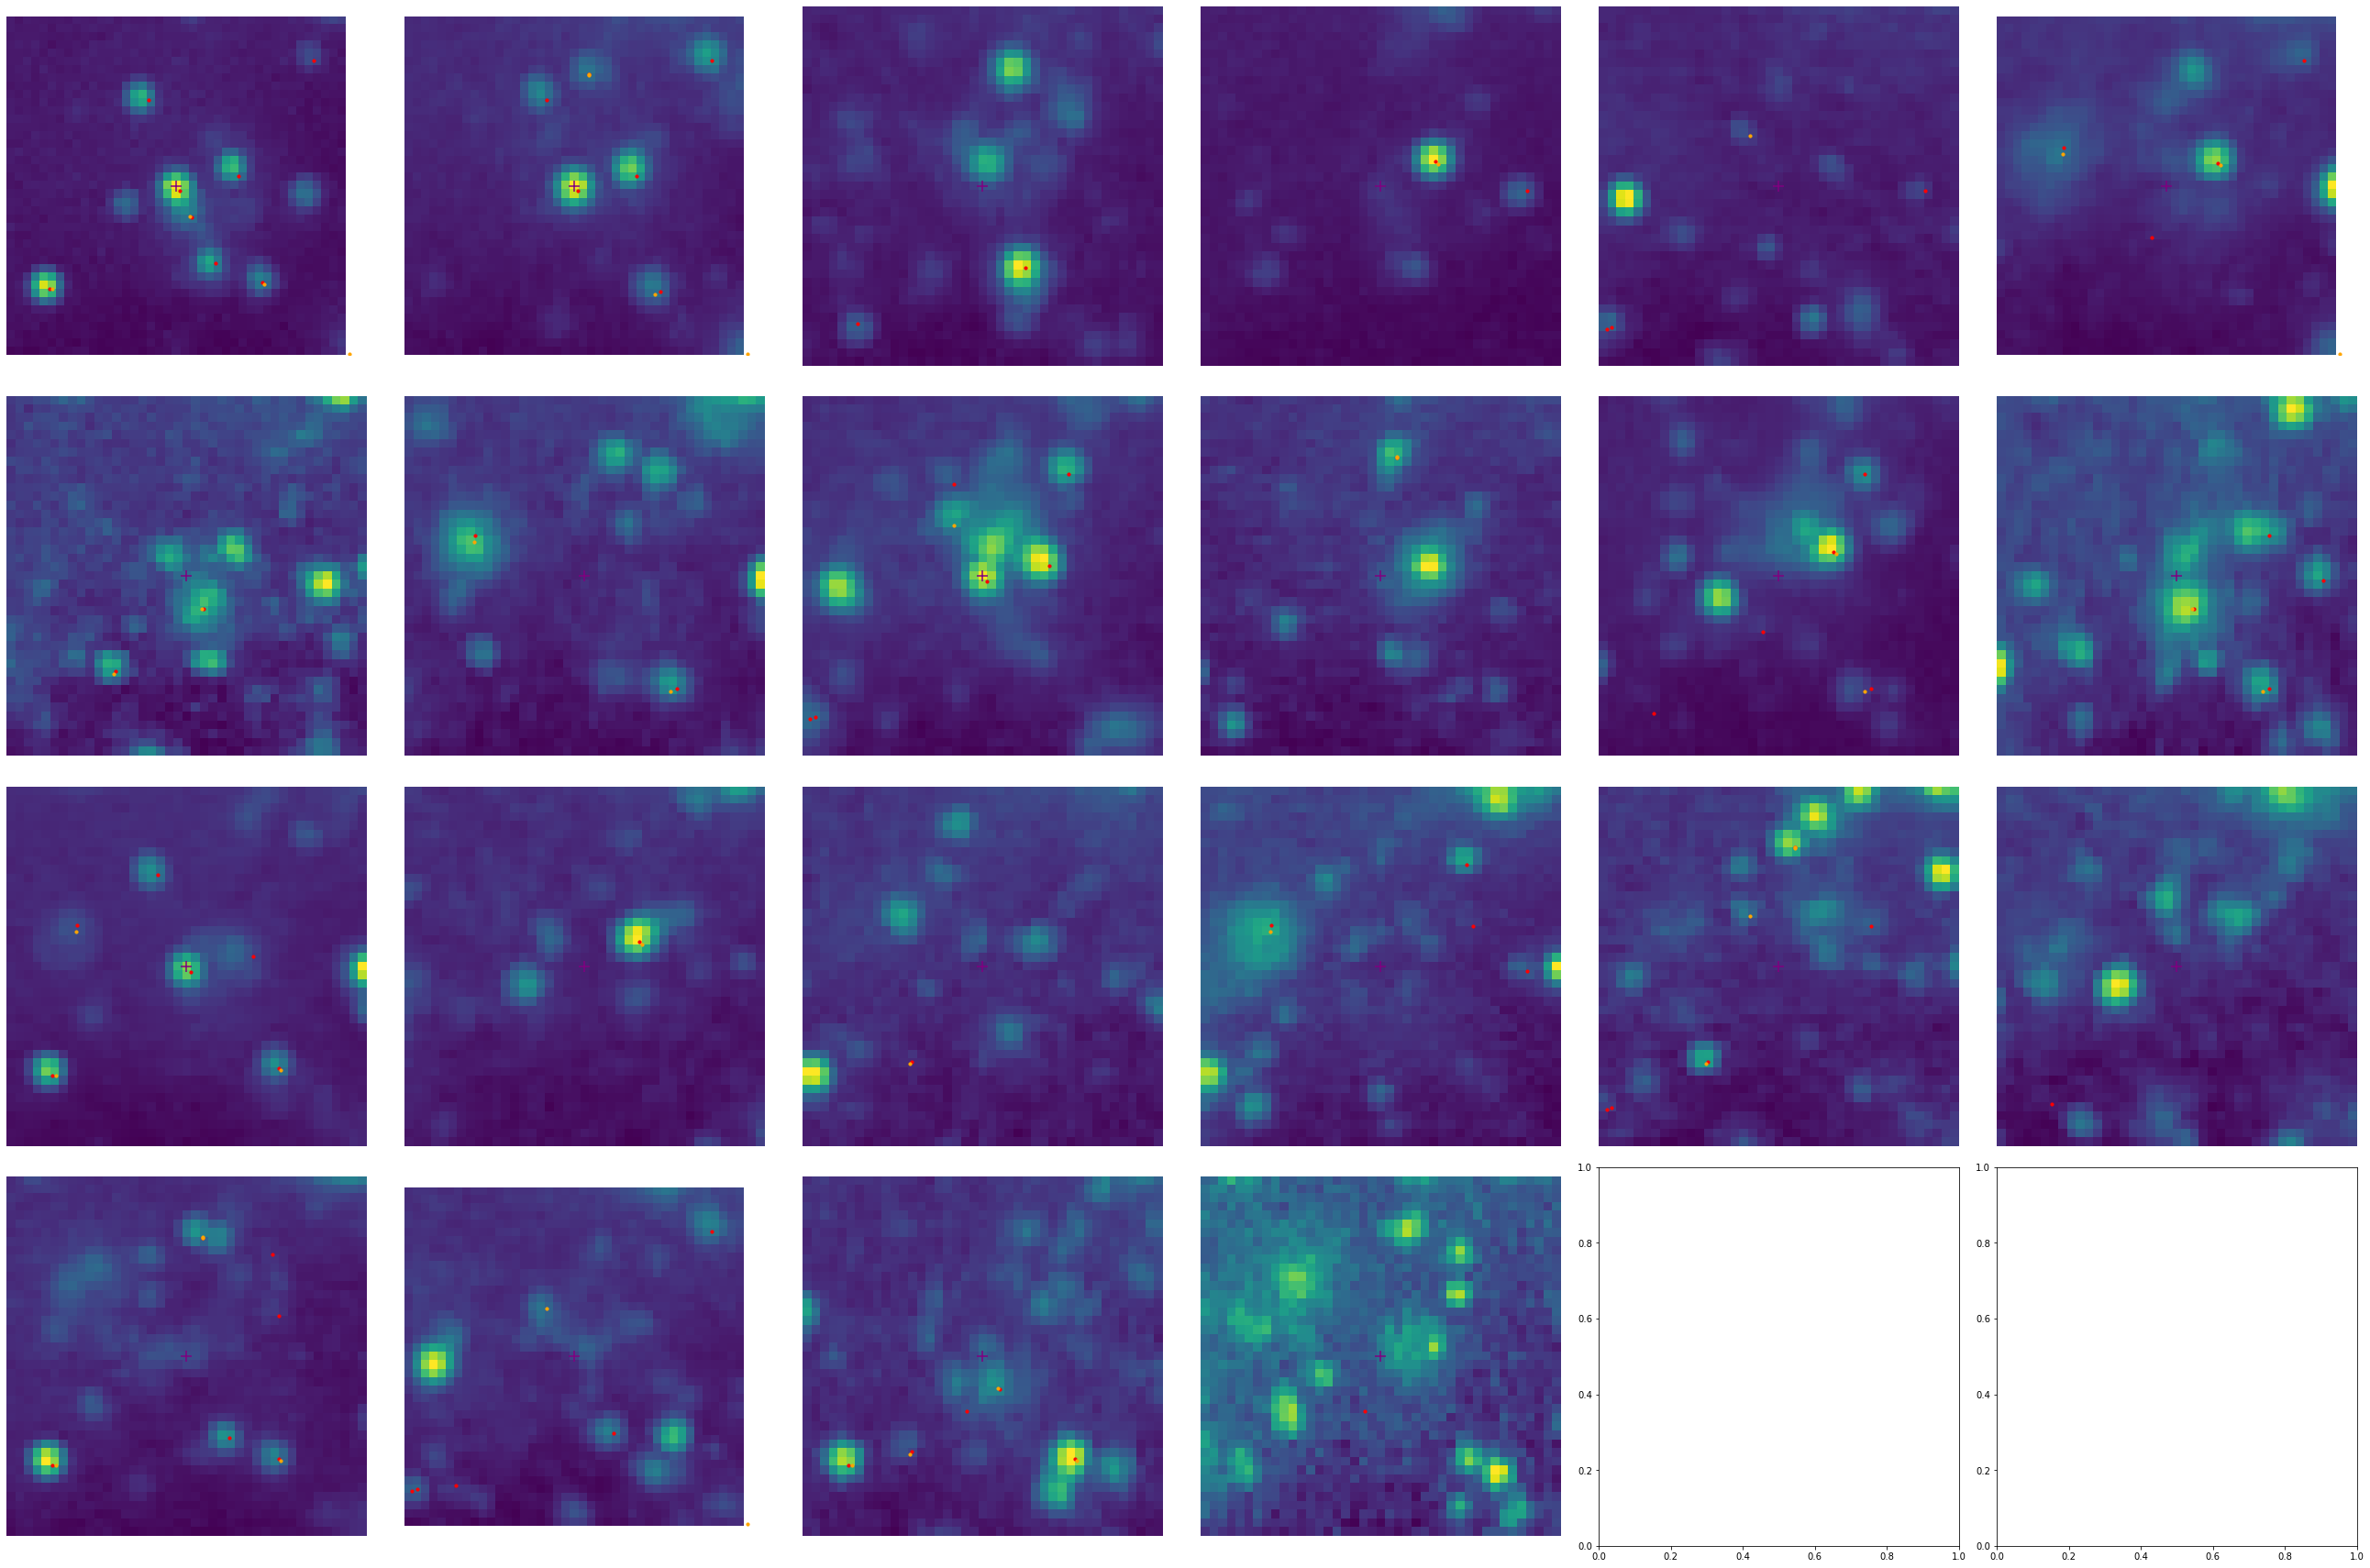

In [53]:
fig, plot_vol, dfs = plot_channels(cpu(img_3d[0][:,:,500:1500,500:1500]), n_rows=4, dfs=[nm_to_px(bench_sub), nm_to_px(res_sub)], codebook=code_ref, vmax=None, center=[255,136,4], crop_sz=20)

In [481]:
bench_sub['z'] = bench_sub['z']/1000
res_sub['z'] = res_sub['z']/100

In [482]:
from decode_fish.funcs.evaluation import matching
perf_dict, match_df, shifts = matching(bench_sub,  res_sub.nsmallest(9000, 'comb_sig'), tolerance=500,)

Recall: 0.502
Precision: 0.492
Jaccard: 33.067
RMSE_vol: 65.858
Eff_3d: 25.406
FN: 4403.0 FP: 4568.0
Num. matches: 4432.000
Shift: 4.37,3.06,0.63


In [170]:
from decode_fish.funcs.evaluation import matching
perf_dict, match_df, shifts = matching(bench_sub,  res_sub.nsmallest(5000, 'comb_sig'), tolerance=500,)

Recall: 0.345
Precision: 0.609
Jaccard: 28.244
RMSE_vol: 62.003
Eff_3d: 21.834
FN: 5788.0 FP: 1953.0
Num. matches: 3047.000
Shift: -0.11,-1.12,1.08


In [483]:
from decode_fish.funcs.evaluation import matching
perf_dict, match_df, shifts = matching(bench_sub,  res_sub.nsmallest(5000, 'comb_sig'), tolerance=500,)

Recall: 0.356
Precision: 0.628
Jaccard: 29.384
RMSE_vol: 60.865
Eff_3d: 23.105
FN: 5693.0 FP: 1858.0
Num. matches: 3142.000
Shift: 5.32,3.44,0.64


8835 9000


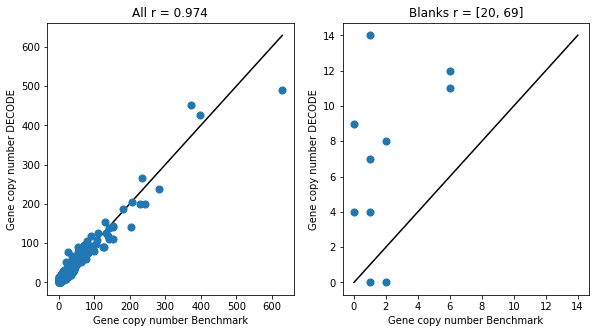

In [484]:
plot_gene_panels(res_sub.nsmallest(9000, 'comb_sig'), bench_sub, targets)

8835 5000


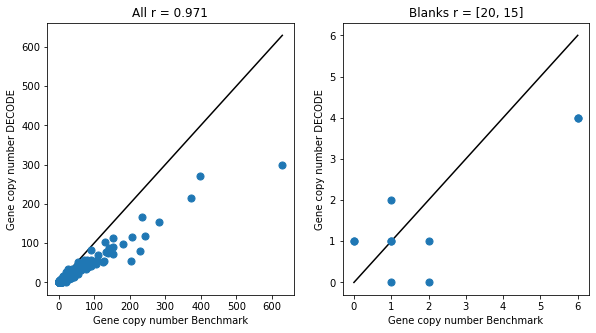

In [485]:
plot_gene_panels(res_sub.nsmallest(5000, 'comb_sig'), bench_sub, targets)

(array([ 358., 1286.,  749.,  329.,  143.,   74.,   38.,   13.,    5.,
           5.]),
 array([ 14.964024,  27.701696,  40.43937 ,  53.177044,  65.91472 ,
         78.65239 ,  91.39007 , 104.12774 , 116.86541 , 129.60309 ,
        142.34076 ], dtype=float32),
 <BarContainer object of 10 artists>)

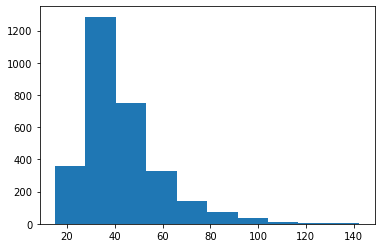

In [338]:
plt.hist(res_sub.nsmallest(3000, 'comb_sig')['int'])

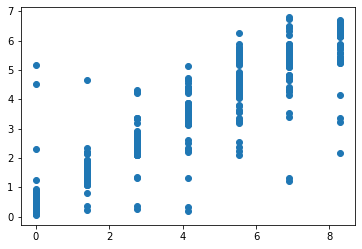

In [486]:
plt.scatter(match_df['z_tar'], match_df['z_pred'])

In [487]:
res_high = res_sub.nlargest(5000, 'comb_sig')
res_low = res_sub.nsmallest(5000, 'comb_sig')

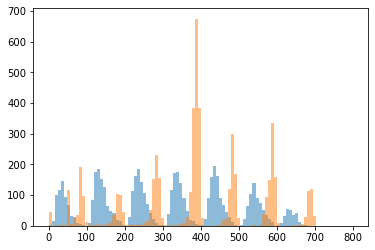

In [488]:
_ = plt.hist(res_low['z']*100, alpha=0.5, bins=np.linspace(0,800,101))
_ = plt.hist(res_high['z']*100, alpha=0.5, bins=np.linspace(0,800,101))

In [84]:
matches, bench_match = match_bench(res_df.nsmallest(15000, 'comb_sig'), bench_df)

[-64.44552350347162, -70.06390400883089, -56.111649826769195]
Recall: 0.056
Precision: 0.173
Jaccard: 4.385
RMSE_vol: 125.632
Eff_3d: -14.403
FN: 44022.0 FP: 12412.0
Num. matches: 2588.000
Shift: 0.11,-1.06,-41.98
